In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Define the constants

In [2]:
# Define the toy model parameters

# Discrete/continuum boundary
discrete_continuum_boundary = 10

# Define the discrete energy levels
discrete_energies = np.array([0, 3, 5, 7, 8, 9, 9.5, 10])
discrete_level_number = len(discrete_energies)
# And the transition strengths between them
dcw = np.random.rand(discrete_level_number, discrete_level_number)
discrete_decay_widths = dcw + dcw.T
# Diagonal must be 0
np.fill_diagonal(discrete_decay_widths, 0)

# Define the continuum energy levels via an event density function
# Backshifted Fermi Gas
def rho_f(energy):
    return 1/(1 + np.exp((energy - discrete_continuum_boundary)/1.1))

def rho_0(energy):
    return 0.01

def level_density(energy):
    return 100 * (1/rho_f(energy) + 1/rho_0(energy))**(-1)

# Define the continuum transition strengths
# Just a sine wave lmao (transition strenght should be 0 for E_gamma = 0 and smooth at 0)
def transition_strength(gamma_energy):
    ts = np.sin(gamma_energy)**2 * 5 * np.exp(-gamma_energy/10)

    if isinstance(gamma_energy, np.ndarray):
        ts[gamma_energy <= 0] = 0
    elif gamma_energy <= 0:
        ts = 0
    
    return ts

# (differential) decay width
def differential_decay_width(energy, gamma_energy):
    return level_density(energy) * transition_strength(gamma_energy)


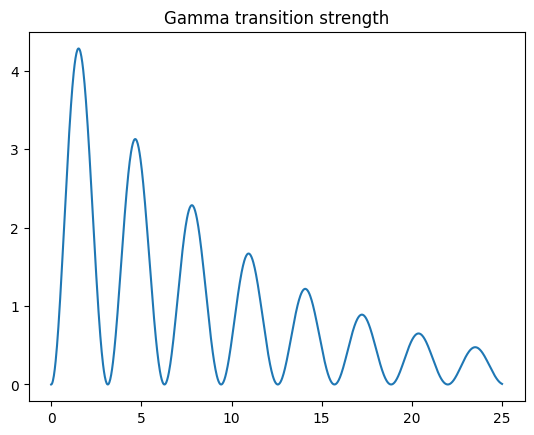

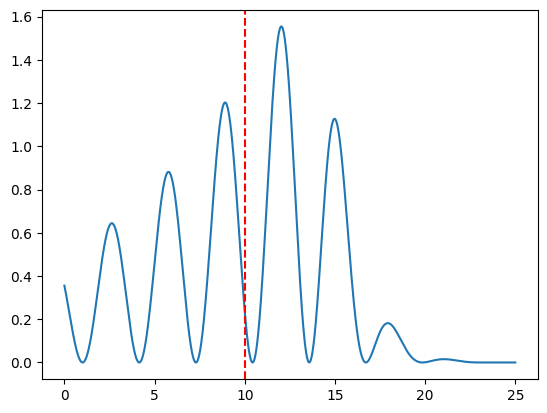

In [3]:
energies = np.linspace(0, 25, 1000)
# Starting energy
start_energy = 23

# plt.plot(energies, event_density(energies))
# # Vertical dashed line at the discrete/continuum boundary
# plt.axvline(discrete_continuum_boundary, linestyle='--', color='red')
#plt.yscale('log')

plt.figure()
plt.plot(energies, transition_strength(energies))
plt.title("Gamma transition strength")

gamma_energies = start_energy - energies
plt.figure()
plt.plot(energies, differential_decay_width(energies, gamma_energies))
plt.axvline(discrete_continuum_boundary, linestyle='--', color='red')

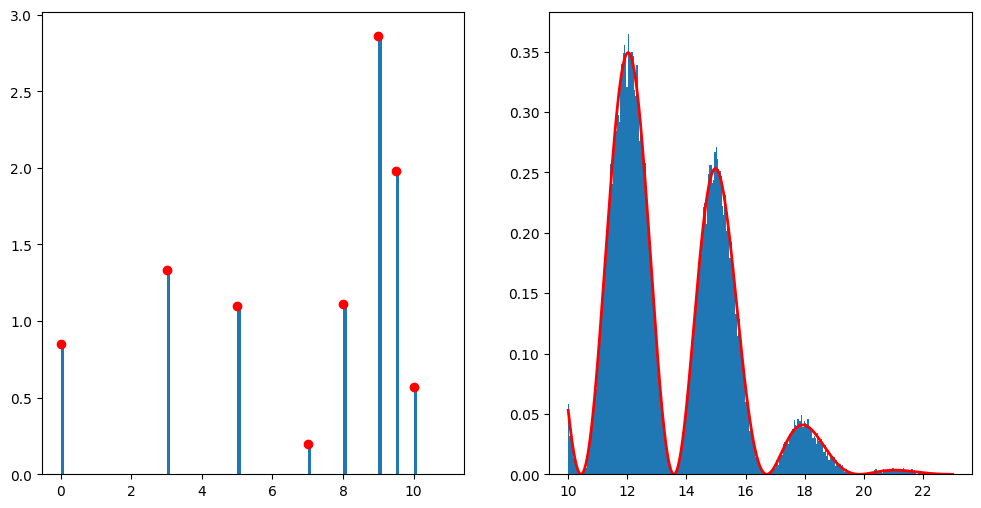

In [4]:
def sample_energy(start_energy):
    energies = np.linspace(discrete_continuum_boundary, start_energy, 1000)
    gamma_energies = start_energy - energies

    # First, see if you are sampling a discrete or continuum level
    # Total discrete decay width is just the sum of the gamma transition strengths
    total_decay_width_to_discrete = 0
    for i in range(discrete_level_number):
        total_decay_width_to_discrete +=  transition_strength(start_energy - discrete_energies[i])
    # Total continuum decay width is the integral of the differential decay width over the continuum
    total_decay_width_to_continuum = np.sum(differential_decay_width(energies, gamma_energies) * np.diff(energies)[0])
    
    #print(total_decay_width_to_discrete, total_decay_width_to_continuum)

    # Sample a random number between 0 and the total decay width
    sampled_decay_width = np.random.uniform(0, total_decay_width_to_discrete + total_decay_width_to_continuum)
    # If the sampled decay width is below the total decay width to discrete, sample a discrete level
    if sampled_decay_width < total_decay_width_to_discrete:
        sampled_level = np.random.choice(discrete_level_number, p=transition_strength(start_energy - discrete_energies)/total_decay_width_to_discrete)
        sampled_energy = discrete_energies[sampled_level]
        return sampled_energy

    # Otherwise, sample a continuum level
    # Find the maximum of the differential decay width
    top_y = np.max(differential_decay_width(energies, gamma_energies))
    accepted = False
    while not accepted:
        # Sample an energy
        sampled_energy = np.random.uniform(discrete_continuum_boundary, start_energy)
        # Sample a y value
        sampled_y = np.random.uniform(0, top_y)
        # Check if the sampled y value is below the event density function
        if sampled_y < differential_decay_width(sampled_energy, start_energy - sampled_energy):
            accepted = True
    return sampled_energy

# Sample a continuum level given a starting energy, with no possibility of discrete levels
def sample_continuum_energy(start_energy):
    energies = np.linspace(discrete_continuum_boundary, start_energy, 1000)
    gamma_energies = start_energy - energies

    # total_decay_width_to_continuum = np.sum(differential_decay_width(energies, gamma_energies) * np.diff(energies)[0])

    # Sample a continuum level
    # Find the maximum of the differential decay width
    top_y = np.max(differential_decay_width(energies, gamma_energies))
    accepted = False
    while not accepted:
        # Sample an energy
        sampled_energy = np.random.uniform(discrete_continuum_boundary, start_energy)
        # Sample a y value
        sampled_y = np.random.uniform(0, top_y)
        # Check if the sampled y value is below the event density function
        if sampled_y < differential_decay_width(sampled_energy, start_energy - sampled_energy):
            accepted = True
    return sampled_energy

def sample_discrete_level(start_level):
    dst_level = discrete_decay_widths[start_level, :start_level]

    available_level_number = len(dst_level)

    sampled_level = np.random.choice(available_level_number, p=dst_level/np.sum(dst_level))

    return sampled_level

sampled = []
for i in range(100000):
    sampled.append(sample_energy(start_energy))
sampled = np.array(sampled)

# plt.figure()
# energies = np.linspace(discrete_continuum_boundary, start_energy, 1000)
# plt.hist(sampled, bins=300, density=True)
# norm = np.sum(differential_decay_width(energies, start_energy - energies) * np.diff(energies)[0])
# plt.plot(energies, differential_decay_width(energies, start_energy - energies)/norm, linewidth=2, color='red')

# Create two adjacent plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
_, bins, _ = ax1.hist(sampled[sampled <= discrete_continuum_boundary], bins=np.arange(0, discrete_continuum_boundary * 1.1, 0.1), density=True)
energies = np.linspace(discrete_continuum_boundary, start_energy, 1000)
total_decay_width_to_discrete = 0
for i in range(discrete_level_number):
    total_decay_width_to_discrete +=  transition_strength(start_energy - discrete_energies[i])
ax1.scatter(discrete_energies, transition_strength(start_energy - discrete_energies)/total_decay_width_to_discrete/np.diff(bins)[0], color='red')

ax2.hist(sampled[sampled > discrete_continuum_boundary], bins=300, density=True)
norm = np.sum(differential_decay_width(energies, start_energy - energies) * np.diff(energies)[0])
ax2.plot(energies, differential_decay_width(energies, start_energy - energies)/norm, linewidth=2, color='red')


In [5]:
def continuum_circuit(start_energy, discrete_continuum_boundary):
    current_energy = start_energy
    energy_path = [current_energy]
    # Wile the current energy is above the discrete/continuum boundary...
    while current_energy > discrete_continuum_boundary:
        # Sample an energy from the event density function below the current energy
        new_energy = sample_energy(current_energy)
        energy_path.append(new_energy)
        current_energy = new_energy
    
    return np.array(energy_path)

def discrete_circuit(start_level):
    current_level = start_level
    level_path = [current_level]
    # While the current energy is above the ground state...
    while current_level > 0:
        # Sample a new energy from the discrete energy levels
        new_level = sample_discrete_level(current_level)
        level_path.append(new_level)
        current_level = new_level
    
    return np.array(level_path)

In [6]:
start_energy = 23
discrete_continuum_boundary = 10

continuum_energy_path = continuum_circuit(start_energy, discrete_continuum_boundary)
# Find the discrete level that coincides with the last "continuum" energy
discrete_start_level = np.argmin(np.abs(discrete_energies - continuum_energy_path[-1]))

discrete_level_path = discrete_circuit(discrete_start_level)
discrete_energy_path = discrete_energies[discrete_level_path]


print(continuum_energy_path)
print(discrete_energy_path)
print(discrete_level_path)

[23.         12.56658752 11.17998563 10.9593848   0.        ]
[0.]
[0]


Text(0.05, 23, 'E$_i$')

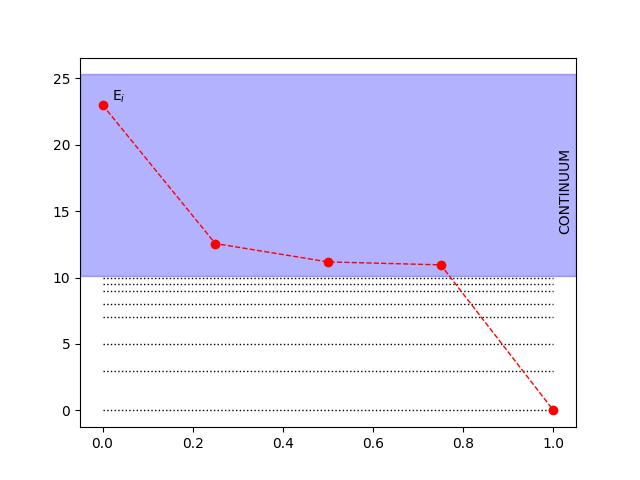

In [7]:
%matplotlib widget
plt.figure()
# Plot the continuum energy range (from discrete/continuum boundary to start energy) as a rectangle
plt.axhspan(discrete_continuum_boundary * 1.01, start_energy * 1.1, alpha=0.3, color='blue')
# Add a "CONTINUUM" label to the right, rotated 90 degrees
plt.text(1.01, (discrete_continuum_boundary + start_energy)/2, 'CONTINUUM', rotation=90, verticalalignment='center', horizontalalignment='left')
# Plot the discrete energy levels as horizontal lines
plt.hlines(discrete_energies, 0, 1, color='black', linewidth=1, linestyles='dotted')

# Join the continuum and discrete paths
full_level_path = np.concatenate((continuum_energy_path[:-1], discrete_energy_path))

# Plot the continuum energy path as a scatter joined with dashed lines
# plt.plot(np.linspace(0, 1, len(continuum_energy_path)), continuum_energy_path, color='red', linestyle='--', marker='o')
# # Plot the discrete energy path as a scatter joined with dashed lines
# plt.plot(np.linspace(0, 1, len(discrete_energy_path)), discrete_energy_path, color='green', linestyle='--', marker='o')
# Plot the full energy path as a scatter joined with dashed lines
plt.plot(np.linspace(0, 1, len(full_level_path)), full_level_path, color='red', linestyle='--', marker='o', linewidth=1)

# Add a label for the initial energy
plt.text(0.05, start_energy, r'E$_i$', verticalalignment='bottom', horizontalalignment='right')


In [11]:
# Compute the probability of a particular discrete path
def discrete_path_probability(discrete_path):
    probability = 1
    for i in range(1, len(discrete_path)):
        probability *= discrete_decay_widths[discrete_path[i], discrete_path[i - 1]] / np.sum(discrete_decay_widths[discrete_path[i-1], :discrete_path[i-1]])

    return probability


# Compute the probability density (multiplied by some irrelevant factor, as we will be sampling later)
# for a particular continuum path (?). For now number of continuum steps is alowed to be 1 only
def continuum_path_probability_density(final_discrete_level, continuum_energy_path):
    probability_density = 1

    # First, compute the probability of the continuum path
    for i in range(1, len(continuum_energy_path)):
        new_e = continuum_energy_path[i]
        prev_e = continuum_energy_path[i - 1]

        energies = np.linspace(discrete_continuum_boundary, prev_e, 1000)
        total_decay_width_to_continuum = np.sum(differential_decay_width(energies, prev_e - energies)) * np.diff(energies)[0]
        # Also need to consider the probabality that this step didn't just go to a discrete level
        total_decay_width_to_discrete = np.sum(transition_strength(prev_e - discrete_energies))

        probability_density *= differential_decay_width(new_e, prev_e - new_e) / (total_decay_width_to_continuum + total_decay_width_to_discrete)

    # Then, compute the probability of the transition from the last continuum energy to the discrete level
    final_continuum_energy = continuum_energy_path[-1]
    total_decay_width_to_discrete = np.sum(transition_strength(final_continuum_energy - discrete_energies))
    energies = np.linspace(discrete_continuum_boundary, final_continuum_energy, 1000)
    total_decay_width_to_continuum = np.sum(differential_decay_width(energies, final_continuum_energy - energies)) * np.diff(energies)[0]

    probability_density *= transition_strength(final_continuum_energy - discrete_energies[final_discrete_level]) / (total_decay_width_to_discrete + total_decay_width_to_continuum)
    
    return probability_density

start_energy = 23
num_points = 200
bin_width = (start_energy - discrete_continuum_boundary)/num_points
prob1 = 0
for i in range(num_points):
    for j in range(discrete_level_number):
        prob_density = continuum_path_probability_density(j, [start_energy, discrete_continuum_boundary + i * bin_width])
        #print(prob_density)
        prob1 += prob_density * bin_width
print(prob1)

prob2 = 0
for i in range(1, num_points):
    for j in range(0, i):
        for k in range(discrete_level_number):
            prob_density = continuum_path_probability_density(k, [start_energy, discrete_continuum_boundary + i * bin_width, discrete_continuum_boundary + j * bin_width])
            prob2 += prob_density * bin_width**2
print(prob2)

# prob3 = 0
# for i in range(2, num_points):
#     for j in range(1, i):
#         for k in range(0, j):
#             for l in range(discrete_level_number):
#                 prob_density = continuum_path_probability_density(l, [start_energy, discrete_continuum_boundary + i * bin_width, discrete_continuum_boundary + j * bin_width, discrete_continuum_boundary + k * bin_width])
#                 prob3 += prob_density * bin_width**3
# print(prob3)

# prob4 = 0
# for i in range(3, num_points):
#     for j in range(2, i):
#         for k in range(1, j):
#             for l in range(0, k):
#                 for m in range(discrete_level_number):
#                     prob_density = continuum_path_probability_density(m, [start_energy, discrete_continuum_boundary + i * bin_width, discrete_continuum_boundary + j * bin_width, discrete_continuum_boundary + k * bin_width, discrete_continuum_boundary + l * bin_width])
#                     prob4 += prob_density * bin_width**4
# print(prob4)

prob0 = 0
for j in range(discrete_level_number):
    prob_density = continuum_path_probability_density(j, [start_energy])
    prob0 += prob_density
print(prob0)

# print(prob0 + prob1 + prob2 + prob3)

0.31803304663311976
0.16008554983666945
0.4874067665844906


In [ ]:
# Sanity check: generate all discrete paths from a given level and check that their probabilities add up to 1.
starting_level = 7

# Generate all possible descending sequences of integers from starting_level to 0
def generate_descending_sequences(starting_level):
    if starting_level == 0:
        return [[0]]
    else:
        sequences = []
        for i in range(starting_level):
            for sequence in generate_descending_sequences(i):
                sequences.append([starting_level] + sequence)
        return sequences

sequences = generate_descending_sequences(starting_level)

total_probability = 0
for sequence in sequences:
    total_probability += discrete_path_probability(sequence)
print(total_probability)


In [ ]:
# Naive deexcitation procedure ("binary" sampling)
# Starting energy
start_energy = 23

# Step 1 - sample an energy from the event density function below the starting energy
# (Simple acception/rejection sampling)
energies = np.linspace(0, start_energy, 1000)
gamma_energies = start_energy - energies

sampled_energy = sample_energy(start_energy)

print("Sampled energy: ", sampled_energy)
